In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

In [ ]:
# labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']

labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL', 
                     '6N', 'Amb', 'R', 'Tz', 'Sol', 'RtTg', 'LRt', 'LC', 'AP', 'sp5']

n_labels = len(labels)

label_dict = dict([(l,i) for i, l in enumerate(labels)])

In [ ]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [ ]:
volume1 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD589_annotation.bp'))[::2, ::2, ::2]
atlas_ydim, atlas_xdim, atlas_zdim = volume1.shape
print atlas_xdim, atlas_ydim, atlas_zdim

In [ ]:
def parallel_where(l):
    w = np.where(volume1 == l)
    return [w[1], w[0], w[2]]

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

print time.time() - t, 'seconds'

atlas_xmin, atlas_ymin, atlas_zmin = np.min([np.min(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
atlas_xmax, atlas_ymax, atlas_zmax = np.max([np.max(atlas_nzs[l-1], axis=1) for l in range(1, n_labels)], axis=0)
print atlas_xmin, atlas_xmax, atlas_ymin, atlas_ymax, atlas_zmin, atlas_zmax

atlas_centroid = np.array([.5*atlas_xmin+.5*atlas_xmax, .5*atlas_ymin+.5*atlas_ymax, .5*atlas_zmin+.5*atlas_zmax])
print atlas_centroid

atlas_cx, atlas_cy, atlas_cz = atlas_centroid

In [ ]:
# downsample_factor = 16
downsample_factor = 32

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

In [ ]:
atlasAlignOptLogs_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignOptLogs'
if not os.path.exists(atlasAlignOptLogs_dir):
    os.makedirs(atlasAlignOptLogs_dir)

In [ ]:
atlasAlignParams_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams'
if not os.path.exists(atlasAlignParams_dir):
    os.makedirs(atlasAlignParams_dir)

In [ ]:
annotationsViz_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_annotaionsPojectedViz'

In [ ]:
colors = np.loadtxt(os.environ['REPO_DIR'] + '/visualization/100colors.txt')
colors[label_dict['BackG']] = 1.

In [ ]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [ ]:
volume2 = bp.unpack_ndarray_file(os.path.join(volume_dir, 'volume_MD593_annotation.bp'))[::2, ::2, ::2]
test_ydim, test_xdim, test_zdim = volume2.shape
print test_xdim, test_ydim, test_zdim

In [ ]:
volume2_allLabels = []
for l in range(1, n_labels):
    v = (volume2 == l).astype(np.int)
    volume2_allLabels.append(v.copy())
    del v

In [ ]:
# def parallel_where(l):
#     w = np.where(volume2 == l)
#     return [w[1], w[0], w[2]]

# t = time.time()

# test_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(l) for l in range(1, n_labels))

# print time.time() - t, 'seconds'

test_centroid = (.5*test_xdim, .5*test_ydim, .5*test_ydim)
print test_centroid

test_cx, test_cy, test_cz = test_centroid

In [ ]:
def score_transform(tx, ty, tz, A=None):
    
    if A is None:
        A = np.array([[1,0,0], [0,1,0], [0,0,1]])
    
    scores = np.empty((n_labels-1,))
    for l in range(1, n_labels):
                
        test_xs, test_ys, test_zs = (np.dot(A, np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis]) + \
                                    np.asarray([tx + test_cx, 
                                                ty + test_cy, 
                                                tz + test_cz])[:,np.newaxis]).astype(np.int)

        ydim, xdim, zdim = volume2_allLabels[l-1].shape

        valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
                (test_ys < ydim) & (test_xs < xdim) & (test_zs < zdim)

        voxel_probs_valid = volume2_allLabels[l-1][test_ys[valid], test_xs[valid], test_zs[valid]] / 1e4
        
        scores[l-1] = voxel_probs_valid.sum()
        
    del voxel_probs_valid, valid, test_xs, test_ys, test_zs
                
    score = np.sum(scores)
    
    return score

In [ ]:
# def ypr_to_matrix(y,p,r):
#     cz = np.cos(y)
#     sz = np.sin(y)
#     cy = np.cos(p)
#     sy = np.sin(p)
#     cx = np.cos(r)
#     sx = np.sin(r)
    
#     R = np.array([[cz*cy, cz*sy*sx-sz*cx, cz*sy*cx+sz*sx], 
#              [sz*cy, sz*sy*sx+cz*cx, sz*sy*cx-cz*sx],
#              [-sy, cy*sx, cy*cx]])
    
#     return R

In [ ]:
# tx0, ty0, tz0 = (0,0,0)
# yaw0, pitch0, roll0 = (0,0,0)
# sx0, sy0, sz0 = (1,1,1)
# sh_xy0, sh_xz0, sh_yx0, sh_yz0, sh_zx0, sh_zy0 = (0,0,0,0,0,0)

In [ ]:
# def params12_to_matrix(params):
#     tx,ty,tz,y,p,r,sx,sy,sz,sh_xy,sh_xz,sh_yx,sh_yz,sh_zx,sh_zy = params
    
#     cz = np.cos(y)
#     sz = np.sin(y)
#     cy = np.cos(p)
#     sy = np.sin(p)
#     cx = np.cos(r)
#     sx = np.sin(r)
    
#     S = np.array([[sx,0,0],[0,sy,0],[0,0,sz]])
#     Sh = np.array([[1,sh_xy,sh_xz],[sh_yx,1,sh_yz],[sh_zx,sh_zy,1]])
#     Rx = np.array([[1,0,0],[0,cx,-sx],[0,sx,cx]])
#     Ry = np.array([[cy,0,sy],[0,1,0],[-sy,0,cy]])
#     Rz = np.array([[cz,-sz,0],[sz,cx,0],[0,0,1]])
    
#     A = np.dot(Sh, np.dot(np.dot(np.dot(Rz,Ry),Rx), S))

In [ ]:
from skimage.measure import find_contours

def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        if len(contours) > 0:
            if len(contours) > 1:
                sys.stderr.write('%d: region has more than one part\n' % r.label)
                
            contours = sorted(contours, key=lambda c: len(c), reverse=True)
            contours_list = [c-(5,5) for c in contours]
            contour_points[r.label] = [c[np.arange(0, c.shape[0], 10)][:, ::-1] + (min_col, min_row) 
                                for c in contours_list]
            
        elif len(contours) == 0:
            sys.stderr.write('no contour is found\n')
            continue

    #         viz = np.zeros_like(r.filled_image)
    #         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
    #         plt.imshow(viz, cmap=plt.cm.gray);
    #         plt.show();
        
    return contour_points

In [105]:
stack = 'MD593'

In [ ]:
grid_search_iteration_number = 10

params_best_upToNow = (0, 0, 0)
score_best_upToNow = 0

for iteration in range(grid_search_iteration_number):

    logger.info('grid search iteration %d', iteration)

    init_tx, init_ty, init_tz  = params_best_upToNow

    n = int(1000*np.exp(-iteration/3.))

#     sigma_tx = 300*np.exp(-iteration/3.)
#     sigma_ty = 300*np.exp(-iteration/3.)
#     sigma_tz = 100*np.exp(-iteration/3.)

    sigma_tx = 150*np.exp(-iteration/10.)
    sigma_ty = 150*np.exp(-iteration/10.)
    sigma_tz = 50*np.exp(-iteration/10.)

    tx_grid = init_tx + sigma_tx * (2 * np.random.random(n) - 1)
    ty_grid = init_ty + sigma_ty * (2 * np.random.random(n) - 1)
    tz_grid = init_tz + sigma_tz * (2 * np.random.random(n) - 1)

    samples = np.c_[tx_grid, ty_grid, tz_grid]

    import time
    t = time.time()

    scores = Parallel(n_jobs=16)(delayed(score_transform)(tx, ty, tz) for tx, ty, tz in samples)

#     scores = [score_transform(tx, ty, tz) for tx, ty, tz in samples]

    print time.time() - t, 'seconds'

    score_best = np.max(scores)

    tx_best, ty_best, tz_best = samples[np.argmax(scores)]

    if score_best > score_best_upToNow:
        logger.info('%f %f', score_best_upToNow, score_best)

        score_best_upToNow = score_best
        params_best_upToNow = tx_best, ty_best, tz_best

        logger.info('%f %f %f', tx_best, ty_best, tz_best)
        logger.info('\n')

In [ ]:
plt.imshow(dSdyxz[0][1][..., 150])

In [ ]:
dSdyxz = []
for l in range(1, n_labels):
    print labels[l]

    t = time.time()

    g = np.gradient(volume2_allLabels[l-1], 10, 10, 10)

    dSdyxz.append(g)
    
    print time.time() - t, 'seconds'

In [ ]:
# lr1, lr2 = (100., 1e-1)
# lr1, lr2 = (50., 1e-1)
lr1, lr2 = (1., 1e-1)
#     lr1, lr2 = (10., 1e-3)
    # lr1, lr2 = (10., 0)
max_iter_num = 5000

fudge_factor = 1e-6 #for numerical stability

dMdA_historical = np.zeros((12,))

tx_best, ty_best, tz_best = params_best_upToNow
A_best = np.r_[tx_best, ty_best, tz_best, 1,0,0,0,1,0,0,0,1]

lr = np.r_[lr1*np.ones((3,)), lr2*np.ones((9,))]

score_best = 0

scores = []

for iteration in range(max_iter_num):

    logger.info('iteration %d\n', iteration)

    dMdA = np.zeros((12,))

    Amat_best = np.reshape(A_best[3:], (3,3))
    tx_best, ty_best, tz_best = A_best[:3]

    for l in range(1, n_labels):

        ds = np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis]

        xs_prime, ys_prime, zs_prime = (np.dot(Amat_best, ds) + \
                                        np.asarray([tx_best + test_cx, 
                                                    ty_best + test_cy, 
                                                    tz_best + test_cz])[:,np.newaxis]).astype(np.int)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]

            Sx = dSdyxz[l-1][1][ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sy = dSdyxz[l-1][0][ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sz = dSdyxz[l-1][2][ys_prime_valid, xs_prime_valid, zs_prime_valid]

            ds_valid = ds[:, valid]
            dxs, dys, dzs = ds_valid

            dMdA += np.c_[ Sx, Sy, Sz, Sx*dxs, Sx*dys, Sx*dzs, Sy*dxs, Sy*dys, Sy*dzs, Sz*dxs, Sz*dys, Sz*dzs].sum(axis=0)


    dMdA_historical += dMdA**2
    dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

    A_best += lr*dMdA_adjusted

    logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))

#     logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

    tx_best, ty_best, tz_best = A_best[:3]
    Amat_best = np.reshape(A_best[3:], (3,3))

    s = score_transform(tx_best, ty_best, tz_best, Amat_best)
    logger.info('score: %f', s)
    scores.append(s)

    logger.info('\n')

    history_len = 50
    if iteration > 200:
        if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                  np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-2:
            break

    if s > score_best:
        logger.info('Current best')
        best_gradient_descent_params = A_best
        score_best = s


#     np.save(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack}, scores)

del dSdyxz

In [68]:
best_gradient_descent_params

array([-24.84690142,  -6.26848406,  22.99660711,   1.00535647,
         0.15638936,   0.06967413,  -0.16786912,   0.91612731,
         0.14407191,   0.03605663,  -0.18423939,   0.96100649])

In [82]:
z_xy_ratio_downsampled

1.358695652173913

In [107]:
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

(volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_annotation_limits.txt' % {'stack': stack}), dtype=np.int)

map_z_to_section = {}
for s in range(section_bs_begin, section_bs_end+1):
    for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin/2, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin/2 + 1):
        map_z_to_section[z] = s

69 350


In [108]:
test_volume_atlas_projected.shape

(188, 457, 228)

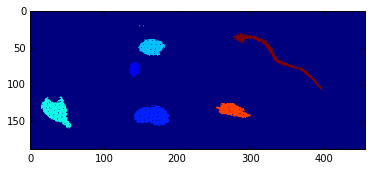

In [73]:
plt.imshow(test_volume_atlas_projected[..., 50])

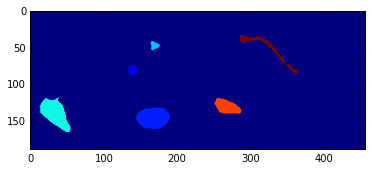

In [72]:
plt.imshow(volume2[..., 50])

In [109]:
tx_best, ty_best, tz_best = best_gradient_descent_params[:3]
Amat_best = np.reshape(best_gradient_descent_params[3:], (3,3))

atlas_nzs_projected_to_test = [(np.dot(Amat_best, vs - atlas_centroid[:, np.newaxis]) + \
                                            np.asarray([tx_best + test_cx, 
                                                        ty_best + test_cy, 
                                                        tz_best + test_cz])[:,np.newaxis]).astype(np.int)
                                for vs in atlas_nzs]

print np.min(atlas_nzs_projected_to_test[0], axis=1)
print np.max(atlas_nzs_projected_to_test[0], axis=1)

test_volume_atlas_projected = np.zeros_like(volume2_allLabels[0], np.int)

for l in range(1, n_labels):

    test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[l-1].astype(np.int)

    valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
        (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

    atlas_xs, atlas_ys, atlas_zs = atlas_nzs[l-1]

    test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
    volume1[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]


del atlas_nzs_projected_to_test

# # bp.pack_ndarray_file(test_volume_atlas_projected, 
# #                      volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

# with open(os.path.join(atlasAlignParams_dir, '%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:
#     f.writelines(' '.join(['%f']*len(params_best_upToNow)) % tuple(params_best_upToNow) + '\n')
#     f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
#     f.writelines(' '.join(['%f']*len(lr)) % tuple(lr) + '\n')
#     f.writelines('%d' % max_iter_num + '\n')

[80 42 14]
[134 125 231]


0


no contour is found
19: region has more than one part


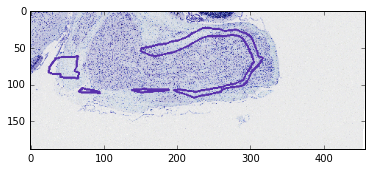

10


9: region has more than one part
19: region has more than one part


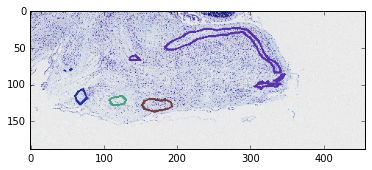

20


1: region has more than one part
19: region has more than one part


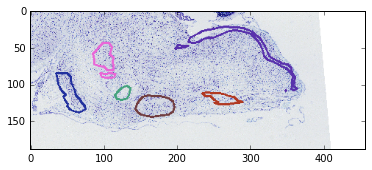

30


16: region has more than one part


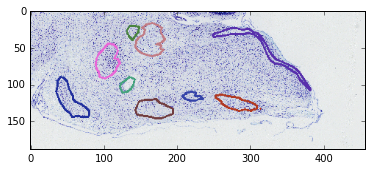

40


19: region has more than one part


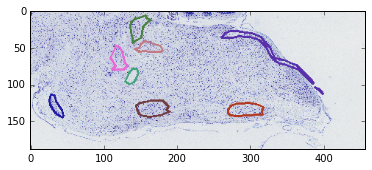

50


no contour is found


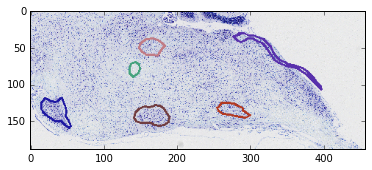

60


3: region has more than one part


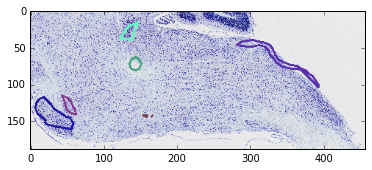

70


19: region has more than one part


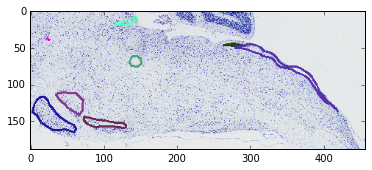

80


15: region has more than one part


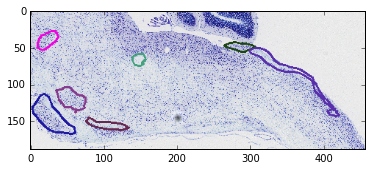

90


12: region has more than one part
13: region has more than one part


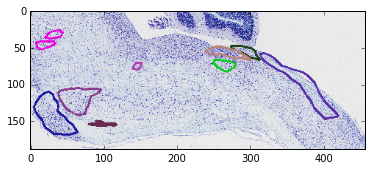

100


7: region has more than one part
15: region has more than one part


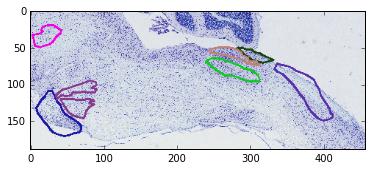

110


5: region has more than one part
no contour is found
19: region has more than one part


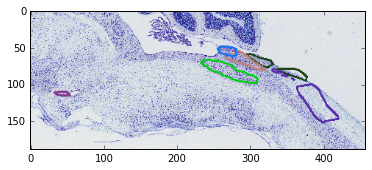

120


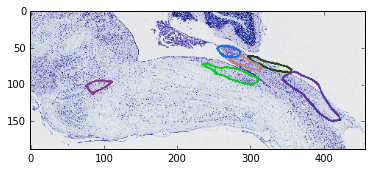

130


13: region has more than one part
14: region has more than one part
15: region has more than one part
18: region has more than one part


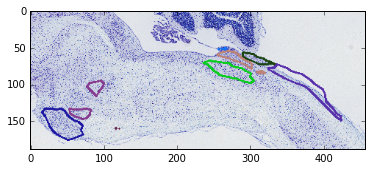

140


15: region has more than one part


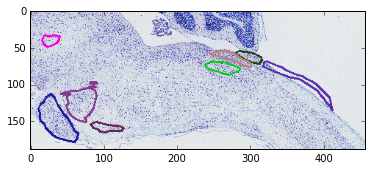

150


19: region has more than one part


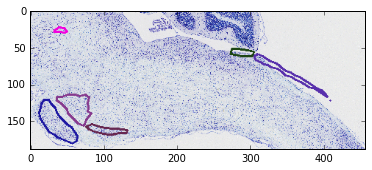

160


2: region has more than one part
19: region has more than one part


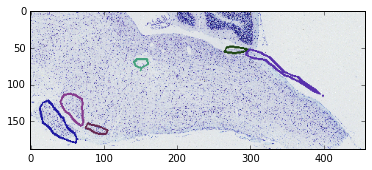

170


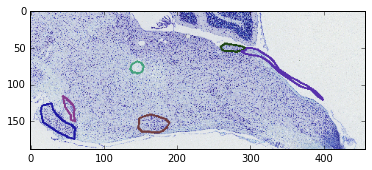

180


17: region has more than one part


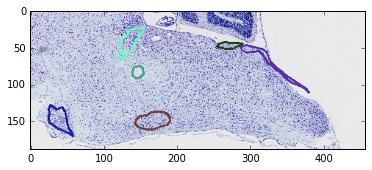

190


9: region has more than one part
19: region has more than one part


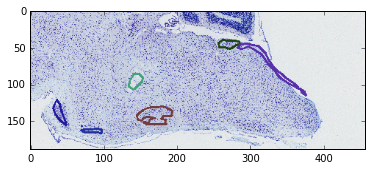

200


19: region has more than one part


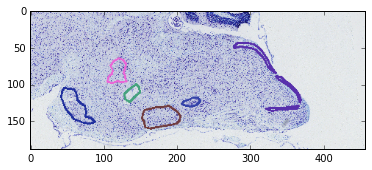

210


19: region has more than one part


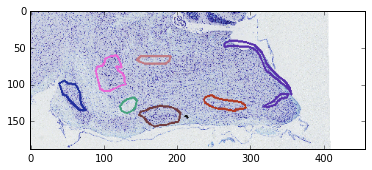

220


19: region has more than one part


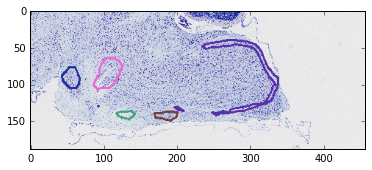

In [111]:
annotationsViz_dir = annotationsViz_rootdir + '/' + stack
if not os.path.exists(annotationsViz_dir):
    os.makedirs(annotationsViz_dir)

for z in range(0, test_zdim, 10):
    print z

    dm = DataManager(stack=stack, section=map_z_to_section[z])
    dm._load_image(versions=['rgb-jpg'])
    viz = dm.image_rgb_jpg[::16, ::16][volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1][::2, ::2].copy()

    projected_cnts = find_contour_points(test_volume_atlas_projected[...,z])

    for label_ind, cnts in projected_cnts.iteritems():
        for cnt in cnts:
            cv2.polylines(viz, [cnt.astype(np.int)], True, tuple((colors[label_ind]*255).astype(np.int)), 2)

#     cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_annotationsProjectedViz_z%(z)04d.jpg' % \
#                 {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
#                 img_as_ubyte(viz[..., [2,1,0]]))

    plt.imshow(viz)
    plt.title('z=%d' % z)
    plt.show()
    
    del viz


# del test_volume_atlas_projected

In [112]:
best_gradient_descent_params

array([-24.84690142,  -6.26848406,  22.99660711,   1.00535647,
         0.15638936,   0.06967413,  -0.16786912,   0.91612731,
         0.14407191,   0.03605663,  -0.18423939,   0.96100649])

In [ ]:
# for stack in ['MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602', 'MD594']:
for stack in ['MD585']:
    


    ################# LOAD TEST VOLUME ######################
    
#     section_bs_begin, section_bs_end = section_range_lookup[stack]
#     print section_bs_begin, section_bs_end

#     (volume_xmin, volume_xmax, volume_ymin, volume_ymax, volume_zmin, volume_zmax) = \
#     np.loadtxt(os.path.join(volume_dir, 'volume_%(stack)s_scoreMap_limits.txt' % {'stack': stack}), dtype=np.int)

#     map_z_to_section = {}
#     for s in range(section_bs_begin, section_bs_end+1):
#         for z in range(int(z_xy_ratio_downsampled*s) - volume_zmin, int(z_xy_ratio_downsampled*(s+1)) - volume_zmin + 1):
#             map_z_to_section[z] = s

#     handler = logging.FileHandler(atlasAlignOptLogs_dir + '/%(stack)s_atlasAlignOpt.log' % {'stack': stack})
#     handler.setLevel(logging.INFO)
#     logger.addHandler(handler)

    ################# GRID SEARCH ######################
    
    grid_search_iteration_number = 1

    params_best_upToNow = (0, 0, 0)
    score_best_upToNow = 0

    for iteration in range(grid_search_iteration_number):

        logger.info('grid search iteration %d', iteration)

        init_tx, init_ty, init_tz  = params_best_upToNow

        n = int(1000*np.exp(-iteration/3.))

        sigma_tx = 300*np.exp(-iteration/3.)
        sigma_ty = 300*np.exp(-iteration/3.)
        sigma_tz = 100*np.exp(-iteration/3.)

        tx_grid = init_tx + sigma_tx * (2 * np.random.random(n) - 1)
        ty_grid = init_ty + sigma_ty * (2 * np.random.random(n) - 1)
        tz_grid = init_tz + sigma_tz * (2 * np.random.random(n) - 1)

        samples = np.c_[tx_grid, ty_grid, tz_grid]

        import time
        t = time.time()

        scores = Parallel(n_jobs=16)(delayed(score_transform)(tx, ty, tz) for tx, ty, tz in samples)

    #     scores = [score_transform(tx, ty, tz) for tx, ty, tz in samples]

        print time.time() - t, 'seconds'

        score_best = np.max(scores)

        tx_best, ty_best, tz_best = samples[np.argmax(scores)]

        if score_best > score_best_upToNow:
            logger.info('%f %f', score_best_upToNow, score_best)

            score_best_upToNow = score_best
            params_best_upToNow = tx_best, ty_best, tz_best

            logger.info('%f %f %f', tx_best, ty_best, tz_best)
            logger.info('\n')
    
        del scores
            
    ################# COMPUTE GRADIENTS ######################

    dSdyxz = []
    for l in range(1, n_labels):
        print labels[l]

        t = time.time()

        g = np.gradient(volume2_allLabels[l-1], 10, 10, 10)

        dSdyxz.append(g)

        print time.time() - t, 'seconds'
    
            
    ################# GRADIENT DESCENT ######################
            
    lr1, lr2 = (100., 1e-1)
#     lr1, lr2 = (10., 1e-3)
    # lr1, lr2 = (10., 0)
    max_iter_num = 5000

    fudge_factor = 1e-6 #for numerical stability

    dMdA_historical = np.zeros((12,))

    tx_best, ty_best, tz_best = params_best_upToNow
    A_best = np.r_[tx_best, ty_best, tz_best, 1,0,0,0,1,0,0,0,1]

    lr = np.r_[lr1*np.ones((3,)), lr2*np.ones((9,))]

    score_best = 0

    scores = []

    for iteration in range(max_iter_num):

        logger.info('iteration %d\n', iteration)

        dMdA = np.zeros((12,))

        Amat_best = np.reshape(A_best[3:], (3,3))
        tx_best, ty_best, tz_best = A_best[:3]

        for l in range(1, n_labels):

            ds = np.array(atlas_nzs[l-1]) - atlas_centroid[:, np.newaxis]

            xs_prime, ys_prime, zs_prime = (np.dot(Amat_best, ds) + \
                                            np.asarray([tx_best + test_cx, 
                                                        ty_best + test_cy, 
                                                        tz_best + test_cz])[:,np.newaxis]).astype(np.int)

            valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
                (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)

            if np.count_nonzero(valid) > 0:

                xs_prime_valid = xs_prime[valid]
                ys_prime_valid = ys_prime[valid]
                zs_prime_valid = zs_prime[valid]

                Sx = dSdyxz[l-1][1][ys_prime_valid, xs_prime_valid, zs_prime_valid]
                Sy = dSdyxz[l-1][0][ys_prime_valid, xs_prime_valid, zs_prime_valid]
                Sz = dSdyxz[l-1][2][ys_prime_valid, xs_prime_valid, zs_prime_valid]

                ds_valid = ds[:, valid]
                dxs, dys, dzs = ds_valid

                dMdA += np.c_[ Sx, Sy, Sz, Sx*dxs, Sx*dys, Sx*dzs, Sy*dxs, Sy*dys, Sy*dzs, Sz*dxs, Sz*dys, Sz*dzs].sum(axis=0)


        dMdA_historical += dMdA**2
        dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

        A_best += lr*dMdA_adjusted

        logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))

        logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

        tx_best, ty_best, tz_best = A_best[:3]
        Amat_best = np.reshape(A_best[3:], (3,3))

        s = score_transform(tx_best, ty_best, tz_best, Amat_best)
        logger.info('score: %f', s)
        scores.append(s)

        logger.info('\n')

        history_len = 50
        if iteration > 200:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-2:
                break

        if s > score_best:
            logger.info('Current best')
            best_gradient_descent_params = A_best
            score_best = s
            
            
#     np.save(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack}, scores)
    
    del dSdyxz
    
    ################# PROJECT ATLAS TO IMAGE ######################
    
#     tx_best, ty_best, tz_best = best_gradient_descent_params[:3]
#     Amat_best = np.reshape(best_gradient_descent_params[3:], (3,3))

#     atlas_nzs_projected_to_test = [(np.dot(Amat_best, vs - atlas_centroid[:, np.newaxis]) + \
#                                                 np.asarray([tx_best + test_cx, 
#                                                             ty_best + test_cy, 
#                                                             tz_best + test_cz])[:,np.newaxis]).astype(np.int)
#                                     for vs in atlas_nzs]

#     print np.min(atlas_nzs_projected_to_test[0], axis=1)
#     print np.max(atlas_nzs_projected_to_test[0], axis=1)

#     test_volume_atlas_projected = np.zeros_like(volume2_allLabels[0], np.int)

#     for l in range(1, n_labels):

#         test_xs, test_ys, test_zs = atlas_nzs_projected_to_test[l-1].astype(np.int)

#         valid = (test_xs >= 0) & (test_ys >= 0) & (test_zs >= 0) & \
#             (test_xs < test_xdim) & (test_ys < test_ydim) & (test_zs < test_zdim)

#         atlas_xs, atlas_ys, atlas_zs = atlas_nzs[l-1]

#         test_volume_atlas_projected[test_ys[valid], test_xs[valid], test_zs[valid]] = \
#         volume1[atlas_ys[valid], atlas_xs[valid], atlas_zs[valid]]


#     del atlas_nzs_projected_to_test

#     bp.pack_ndarray_file(test_volume_atlas_projected, 
#                          volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

#     with open(os.path.join(atlasAlignParams_dir, '%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:
#         f.writelines(' '.join(['%f']*len(params_best_upToNow)) % tuple(params_best_upToNow) + '\n')
#         f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
#         f.writelines(' '.join(['%f']*len(lr)) % tuple(lr) + '\n')
#         f.writelines('%d' % max_iter_num + '\n')

#     annotationsViz_dir = annotationsViz_rootdir + '/' + stack
#     if not os.path.exists(annotationsViz_dir):
#         os.makedirs(annotationsViz_dir)

#     for z in range(0, test_zdim, 10):
#         print z

#         dm = DataManager(stack=stack, section=map_z_to_section[z])
#         dm._load_image(versions=['rgb-jpg'])
#         viz = dm.image_rgb_jpg[::downsample_factor, ::downsample_factor][volume_ymin:volume_ymax+1, 
#                                                                          volume_xmin:volume_xmax+1].copy()

#         projected_cnts = find_contour_points(test_volume_atlas_projected[...,z])

#         for label_ind, cnts in projected_cnts.iteritems():
#             for cnt in cnts:
#                 cv2.polylines(viz, [cnt.astype(np.int)], True, tuple((colors[label_ind]*255).astype(np.int)), 2)

#         cv2.imwrite(annotationsViz_dir + '/%(stack)s_%(sec)04d_annotationsProjectedViz_z%(z)04d.jpg' % \
#                     {'stack': stack, 'sec': map_z_to_section[z], 'z': z}, 
#                     img_as_ubyte(viz[..., [2,1,0]]))

#         del viz


#     del test_volume_atlas_projected
    
#     logger.removeHandler(handler)